# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0944999978877604


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
from ddpg_agent import Agent
from collections import deque
from importlib import reload
import torch
import matplotlib.pyplot as plt
import csv
import pandas as pd

In [11]:
# reload modules when the file has been edited
import ddpg_agent
reload(ddpg_agent)
from ddpg_agent import Agent

In [8]:
# train ddpg function
def ddpg(n_episodes=100, max_timesteps=1000, filename=None):
    """Actor-Critic Learning with DDPG.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_timesteps (int): maximum number of timesteps per episode
        filename (str): csv-file with results from previous training
                        if empty, start training from scratch
    """
    # Initialize score lists
    all_scores = []                    # list containing all scores from each episode (avg over all agents)
    scores_window = deque(maxlen=100)  # deque containing last 100 scores (avg over all agents)
    scores_movavg = []                 # list containing moving average of scores (avg over all agents)
    best_agent_scores = []             # list with best agent score for each episode (individual agent)
    worst_agent_scores = []            # list with worst agent score for each episode (individual agent)
    
    # load scores and weights from previous training run
    if filename:
        # read csv into pd DataFrame
        df = pd.read_csv(filename, sep=';',header=0)
        # get episode_offset of latest checkpoint (ckpt is saved every 10 episodes)
        episode_offset = (df['i_episode'].values.tolist()[-1] // 10) * 10
        # append old score values
        all_scores.extend(df['episode_score'].values.tolist())
        all_scores = all_scores[:episode_offset]
        scores_window.extend(all_scores)
        scores_movavg.extend(df['mov_avg_100'].values.tolist())
        scores_movavg = scores_movavg[:episode_offset]
        best_agent_scores.extend(df['best_agent'].values.tolist())
        best_agent_scores = best_agent_scores[:episode_offset]
        worst_agent_scores.extend(df['worst_agent'].values.tolist())
        worst_agent_scores = worst_agent_scores[:episode_offset]
        # load weights from latest checkpoint
        agent.load_checkpoint('checkpoint_' + str(episode_offset) + '.pth')
        
    # if no previous run has been provided, create new csv file    
    else:
        print('No checkpoint provided, training from scratch...')
        episode_offset = 0
        filename = 'results_temp.csv'
        with open(filename, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            row = ['i_episode', 'episode_score', 'best_agent', 'worst_agent', 'mov_avg_100']
            writer.writerow(row)

    # run episodes (works with 1 and 20 parallel Agents environment)
    for i_episode in range(1+episode_offset, 1+n_episodes+episode_offset):
        # Initialize episode
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations             # get the current states (for each agent)
        scores = np.zeros(num_agents)                     # initialize the score (for each agent)
        agent.reset()                                     # reset agent noise 
        
        # Interact with environment
        for t in range(max_timesteps):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # iterate over experiences and learn
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
                
        # Append scores        
        all_scores.append(np.mean(scores))           # most recent score (avg over all agents)
        scores_window.append(np.mean(scores))        # rolling window (for task target)
        scores_movavg.append(np.mean(scores_window)) # moving average of window
        best_agent_scores.append(np.max(scores))     # best agent score in that episode
        worst_agent_scores.append(np.min(scores))    # worst agent score in that episode
        
        # write scores to csv-file
        with open(filename, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=';')
            row = [i_episode, np.mean(scores), np.max(scores), np.min(scores), np.mean(scores_window)]
            writer.writerow(row)
        
        # Print scores and check if environment has been solved
        if len(env_info.agents) > 1:
            print('\rEpisode {} \tEpisode Average: {:.2f} \tBest Agent Score: {:.2f} \tWorst Agent Score: {:.2f}'.format(
                i_episode, np.mean(scores), np.max(scores), np.min(scores)), end="")
        else:
            print('\rEpisode {} \tEpisode Score: {:.2f} \tMoving Average: {:.2f}'.format(
                i_episode, np.mean(scores), np.mean(scores_window)), end="")            
        if i_episode % 10 == 0:
            print('\nEpisode {} \tAverage Score: {:.2f} \t'.format(
                i_episode, np.mean(scores_window)), end="")
            fpath = 'checkpoint_' + str(i_episode)
            agent.save_checkpoint(filename=fpath)
        if np.mean(scores_window)>=30.0 and i_episode>=100:
            print('\nEnvironment solved in {:d} episodes! \tAverage Score over 100 episodes: {:.2f}'.format(
                i_episode-100, np.mean(scores_window)))
            # Save weights if environment is solved
            agent.save_checkpoint()
            break
            
    return all_scores, scores_movavg, i_episode

In [8]:
# Instatiate agent and train
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
scores, avg_scores, i_episode = ddpg()

No checkpoint provided, training from scratch...
Episode 10 	Episode Average: 4.79 	Best Agent Score: 7.88 	Worst Agent Score: 1.89
Episode 10 	Average Score: 2.63 	checkpoint_10.pth succesfully saved.
Episode 20 	Episode Average: 12.69 	Best Agent Score: 19.03 	Worst Agent Score: 3.82
Episode 20 	Average Score: 6.55 	checkpoint_20.pth succesfully saved.
Episode 30 	Episode Average: 16.65 	Best Agent Score: 25.07 	Worst Agent Score: 10.03
Episode 30 	Average Score: 9.94 	checkpoint_30.pth succesfully saved.
Episode 40 	Episode Average: 28.63 	Best Agent Score: 36.36 	Worst Agent Score: 21.91
Episode 40 	Average Score: 13.55 	checkpoint_40.pth succesfully saved.
Episode 50 	Episode Average: 34.31 	Best Agent Score: 38.84 	Worst Agent Score: 24.04
Episode 50 	Average Score: 17.11 	checkpoint_50.pth succesfully saved.
Episode 60 	Episode Average: 36.90 	Best Agent Score: 39.55 	Worst Agent Score: 33.02
Episode 60 	Average Score: 20.25 	checkpoint_60.pth succesfully saved.
Episode 70 	Epis

In [9]:
# Continue training the agent
# (loads latest checkpoint and previous results for average score tracking)
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
scores, avg_scores, i_episode = ddpg(filename='results_temp.csv')

checkpoint_100.pth successfully loaded.
Episode 107 	Episode Average: 38.32 	Best Agent Score: 39.59 	Worst Agent Score: 34.57
Environment solved in 7 episodes! 	Average Score over 100 episodes: 30.00
checkpoint.pth succesfully saved.


In [40]:
# Plot of rewards function
def plot_rewards(filename):
    # get results and unpack dataframe
    df = pd.read_csv(filename, sep=';',header=0)
    n_episode = df['i_episode'].values.tolist()
    episode_avg_scores = df['episode_score'].values.tolist()
    best_agent_scores = df['best_agent'].values.tolist()
    worst_agent_scores = df['worst_agent'].values.tolist()
    mov_avg = df['mov_avg_100'].values.tolist()
    # make plot
    ax = plt.plot(n_episode, episode_avg_scores, color='grey', label='episode score')
    ax = plt.plot(n_episode, mov_avg, color='orange', label='average')
    ax = plt.plot(n_episode, best_agent_scores, color='lightgrey')
    ax = plt.plot(n_episode, worst_agent_scores, color='lightgrey')
    plt.fill_between(n_episode, worst_agent_scores, best_agent_scores, color='lightgrey')
    plt.title('Training results for 20 parallel agents', fontdict={'fontsize': 14})
    plt.xlabel('episodes', fontdict={'fontsize': 12})
    plt.ylabel('score', fontdict={'fontsize': 12})
    plt.xlim([0, n_episode[-1]])
    plt.hlines(30, xmin=0, xmax=n_episode[-1], colors='0.5', linestyles='dashed', label='target')
    plt.legend();

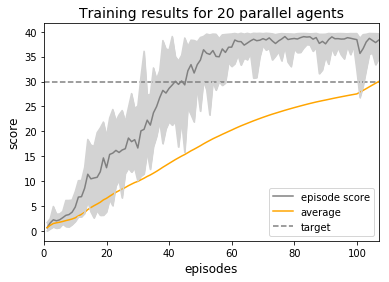

In [41]:
plot_rewards('results_temp.csv')